Processed data already stored as pickel files.
This notebook is focused on hyperparameter tuning and model selection

In [1]:
# import libraries

import joblib
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# import data

X_train = joblib.load("../data/processed/X_train.pkl")
X_test = joblib.load("../data/processed/X_test.pkl")
y_train = joblib.load("../data/processed/y_train.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

In [3]:
# load feature names

with open("../data/processed/feature_columns.json") as f:
    feature_names = json.load(f)

feature_names = [name.replace("cat__", "").replace("num__", "").replace("_", " ") for name in feature_names]

In [4]:
# wrapper function for model tuning

def tune_model(model, X_train, X_test, y_train, y_test, params):

    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        scoring=('accuracy', 'precision', 'recall', 'f1'),
                        refit='recall',
                        cv=5,
                        )
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results = pd.DataFrame(grid.cv_results_)
    best_model = grid.best_estimator_
    best_scores = grid.best_score_
    best_params = grid.best_params_

    return results, best_model, best_scores, best_params

##### Logistic Regression Model

In [5]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.25, 0.5, 0.75, 1.0],
    'class_weight': [None],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [550, 600, 650]
}


In [6]:
model = LogisticRegression()

lr_results, lr_best_model, lr_best_scores, lr_best_params = tune_model(model, X_train, X_test, y_train, y_test, params)

d:\customerchurn\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "d:\customerchurn\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\customerchurn\venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\customerchurn\venv\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1210, in fit
    solver = _check_solv

In [7]:
lr_best_model

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.25
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,550
,multi_class,'deprecated'


In [8]:
joblib.dump(lr_best_model, "../models/logisticregression.pkl")

['../models/logisticregression.pkl']

In [9]:
lr_best_params

{'C': 0.25,
 'class_weight': None,
 'max_iter': 550,
 'penalty': 'l1',
 'solver': 'saga'}

In [10]:
# Top 5 models

top_lr = lr_results.sort_values(by='mean_test_recall', ascending=False).head(5)
top_lr['Model'] = 'LogisticRegression'

In [11]:
top_lr = top_lr[['Model', 'params',
'mean_test_accuracy',
'mean_test_precision',
'mean_test_recall',
'mean_test_f1']]

top_lr

,Model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
3,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783656,0.764551,0.819855,0.791081
11,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783535,0.764380,0.819855,0.790988
19,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783656,0.764551,0.819855,0.791081
9,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783898,0.765010,0.819613,0.791220
57,LogisticRegression,"{'C': 0.75, 'class_weight': None, 'max_iter': ...",0.783898,0.765066,0.819613,0.791235


##### Random Forest Models

In [12]:
rf_params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [2, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt', 'log2']
}


In [13]:
model = RandomForestClassifier(random_state=42)

rf_results, rf_best_model, rf_best_scores, rf_best_params = tune_model(model, X_train, X_test, y_train, y_test, rf_params)

In [14]:
rf_best_model

,n_estimators,200
,criterion,'log_loss'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
joblib.dump(rf_best_model, "../models/randomforest.pkl")

['../models/randomforest.pkl']

In [16]:
rf_best_params

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [17]:
top_rf = rf_results.sort_values(by='mean_test_recall', ascending=False).head(5)
top_rf['Model'] = 'RandomForest'
top_rf = top_rf[['Model', 'params', 'mean_test_accuracy',
'mean_test_precision',
'mean_test_recall',
'mean_test_f1']]

top_rf

,Model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
193,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.850242,0.841992,0.86247,0.847456
196,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.850242,0.841992,0.86247,0.847456
166,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.86247,0.846138
163,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.86247,0.846138
169,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.86247,0.846138


##### Top 10 Models from both

In [18]:
top_10 = pd.concat([top_lr, top_rf])
top_10

,Model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
3,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783656,0.764551,0.819855,0.791081
11,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783535,0.764380,0.819855,0.790988
19,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783656,0.764551,0.819855,0.791081
9,LogisticRegression,"{'C': 0.25, 'class_weight': None, 'max_iter': ...",0.783898,0.765010,0.819613,0.791220
57,LogisticRegression,"{'C': 0.75, 'class_weight': None, 'max_iter': ...",0.783898,0.765066,0.819613,0.791235
193,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.850242,0.841992,0.862470,0.847456
196,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.850242,0.841992,0.862470,0.847456
166,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.862470,0.846138
163,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.862470,0.846138
169,RandomForest,"{'criterion': 'log_loss', 'max_depth': None, '...",0.848789,0.839513,0.862470,0.846138


In [19]:
top_10.to_csv("../data/top_10_models.csv")

##### Using best RF model

In [20]:
y_pred = rf_best_model.predict(X_test)

report = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

print(report)

{'Accuracy': 0.7711442786069652, 'Precision': 0.5643564356435643, 'Recall': 0.6096256684491979, 'F1 Score': 0.5861182519280206}


In [21]:
y_pred = lr_best_model.predict(X_test)

report = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

print(report)

{'Accuracy': 0.7313432835820896, 'Precision': 0.4966101694915254, 'Recall': 0.7834224598930482, 'F1 Score': 0.6078838174273858}


##### Model Explanation using SHAP

In [22]:
X_train_df = pd.DataFrame(X_train, columns=feature_names)

In [23]:
import shap

explainer = shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_train_df.sample(1))


d:\customerchurn\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
shap_values = np.transpose(shap_values, (2, 0, 1))

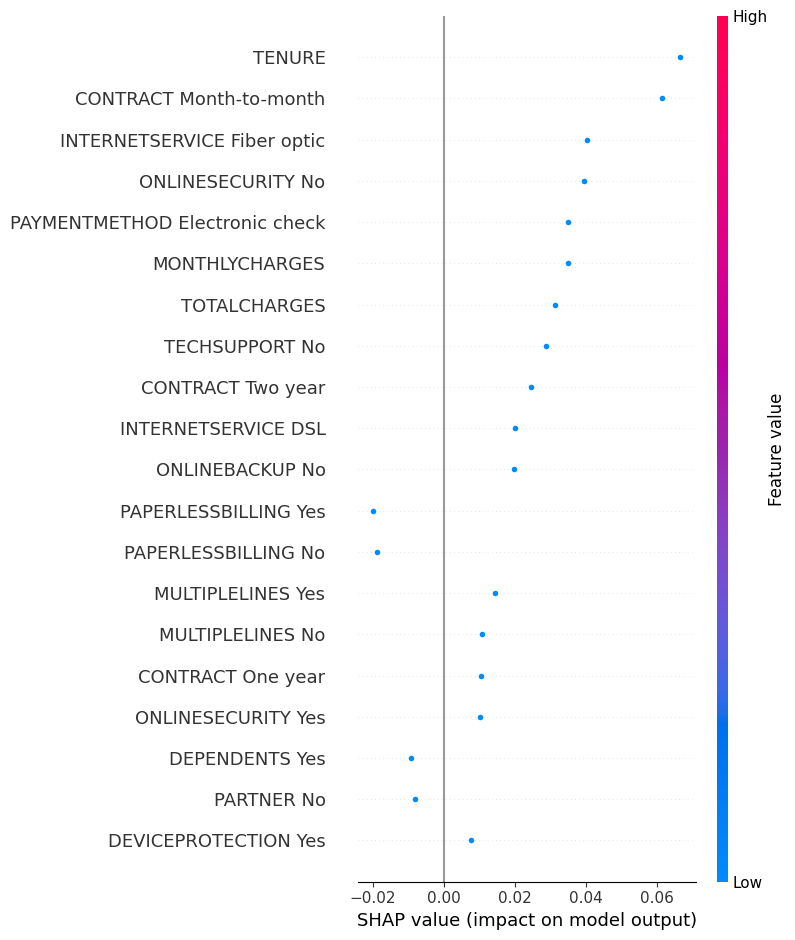

In [26]:
# summary plot

shap.summary_plot(shap_values[1], X_train_df.sample(1))

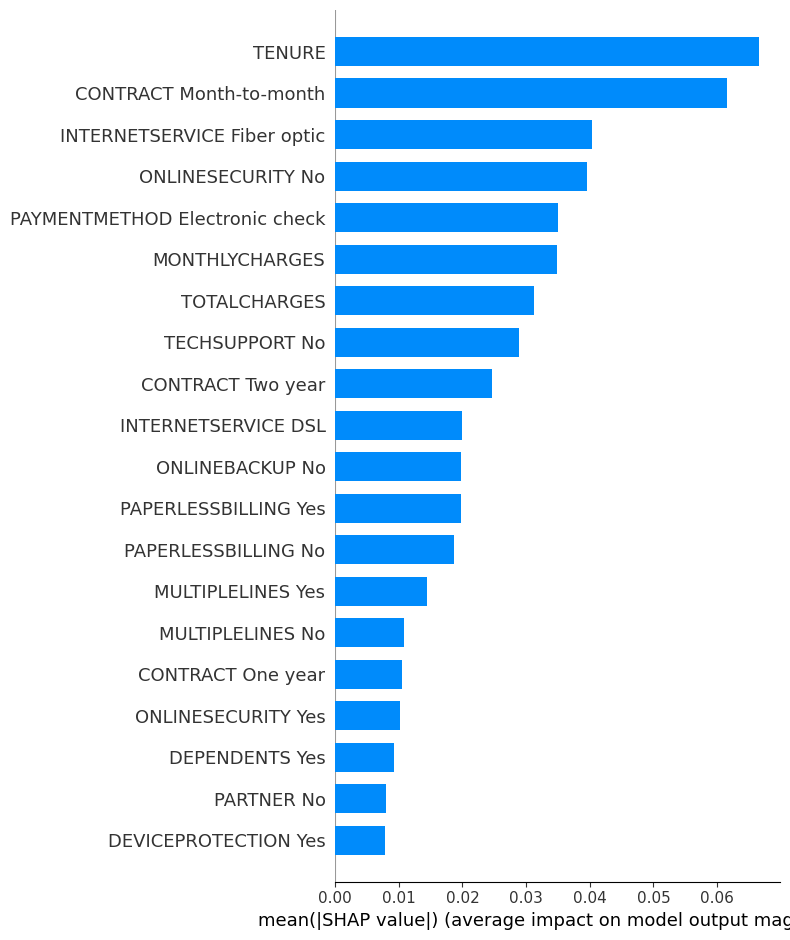

In [27]:
# Bar Plot (Mean SHAP value per feature)

shap.summary_plot(shap_values[1], X_train_df.sample(1), plot_type="bar")


✅ Summary: Top 10 Models Comparison

🔹 Top 5 Logistic Regression Models

| Rank | Model ID | Solver    | C    | Max Iter | Accuracy | Precision | Recall | F1 Score |
| ---- | -------- | --------- | ---- | -------- | -------- | --------- | ------ | -------- |
| 1    | 57       | liblinear | 0.75 | 600      | 0.784    | 0.7651    | 0.8196 | 0.7912   |
| 2    | 9        | liblinear | 0.25 | 600      | 0.784    | 0.7650    | 0.8196 | 0.7912   |
| 3    | 3        | saga      | 0.25 | 550      | 0.784    | 0.7646    | 0.8199 | 0.7911   |
| 4    | 19       | saga      | 0.25 | 650      | 0.784    | 0.7646    | 0.8199 | 0.7911   |
| 5    | 11       | saga      | 0.25 | 600      | 0.784    | 0.7644    | 0.8199 | 0.7910   |

📌 Observation:
All models are nearly identical in performance, with slight solver and regularization differences.
F1 scores cluster tightly around 0.791, suggesting stable but moderate performance.

🔹 Top 5 Random Forest Models

| Rank | Model ID | n\_estimators | max\_features | min\_samples\_split | Accuracy | Precision | Recall | F1 Score |
| ---- | -------- | ------------- | ------------- | ------------------- | -------- | --------- | ------ | -------- |
| 1    | 193      | 200           | log2          | 3                   | 0.850    | 0.842     | 0.8625 | 0.8475   |
| 2    | 196      | 200           | log2          | 4                   | 0.850    | 0.842     | 0.8625 | 0.8475   |
| 3    | 166      | 200           | sqrt          | 3                   | 0.849    | 0.8395    | 0.8625 | 0.8461   |
| 4    | 163      | 200           | sqrt          | 2                   | 0.849    | 0.8395    | 0.8625 | 0.8461   |
| 5    | 169      | 200           | sqrt          | 4                   | 0.849    | 0.8395    | 0.8625 | 0.8461   |


📌 Observation:
Random Forest models clearly outperform Logistic Regression in every metric, especially:
- Accuracy: ~0.850 vs 0.784
- F1 Score: ~0.847 vs 0.791
- Precision & Recall: both consistently higher

Also, the best Random Forest models use:
- criterion='log_loss' (for probabilistic improvement)
- min_samples_leaf=2
- n_estimators=200

🏁 Recommendation: Final Model Selection
✅ Final Model Suggestion:
Random Forest Model ID 193 or 196
Both deliver:
- Highest F1 Score: 0.8475
- Excellent balance between precision (0.842) and recall (0.8625)
- Better generalization capability than linear models for this dataset

🧠 Why Not Logistic Regression?
- While simpler and interpretable, it plateaus at ~0.79 F1, which is clearly behind
- Might still be useful as a benchmark or baseline, but not for production